In [38]:
%run ../../multibench.py

<Figure size 1080x216 with 0 Axes>

In [39]:
!mccortex

usage: mccortex <K> [<cmd> ...]
  Wrapper to find the correct mccortex binary given kmer size (K)


In [41]:
import sys
import os
import shutil
import numpy as np
import glob

# Move two upper directories, import benchmark, revert cwd
sys.path.append("../..")
import cmdbench
sys.path.pop()

# Summarize numpy array if it has more than 10 elements
np.set_printoptions(threshold=10)

input_dir = 'input'
input_files_1 = [os.path.basename(f) for f in glob.glob('input/*_1.fastq.gz')]
input_samples = [f.replace('_1.fastq.gz','') for f in input_files_1]
print(input_samples)

bigsi_dir = 'bigsi-data'

['2014C-3655', '2014C-3656', '2014C-3850', '2014C-3840', '2014C-3600', '2014C-3598', '2014C-3907', '2014C-3599', '2014C-3857']


In [42]:
def clean_if_exists(path):
    if os.path.exists(path):
        if(os.path.isfile(path)):
            os.remove(path)
        else:
            shutil.rmtree(path)
            os.mkdir(path)
def get_last_n_lines(string, n):
    return "\n".join(string.split("\n")[-n:])



In [43]:
%%bash
# You might need to run this before starting jupyter notebook in your shell
export BIGSI_CONFIG=berkleydb.yaml

In [44]:
sample_sizes = [3, 6, 9]

In [45]:
def reset_func():
    # Delete indexed data
    os.system("bigsi delete")

    # Delete all saved bigsi data
    clean_if_exists("bigsi-data")
    clean_if_exists("test-berkeley.db")
    
def benchmark_list_to_results(benchmark_firsts_list):
    return {
        "memory": max(list(map(lambda result: result.memory.max, benchmark_firsts_list))),
        "disk_read": max(list(map(lambda result: result.disk.read_chars, benchmark_firsts_list))),
        "disk_write": max(list(map(lambda result: result.disk.write_chars, benchmark_firsts_list))),
        "runtime": sum(list(map(lambda result: result.process.execution_time, benchmark_firsts_list)))
    }
def sampling_func(input_size):
    return input_samples[:input_size]

mccortex_command = {
    "command": "mccortex 31 build --nkmers 74000000 --threads 8 --kmer 31 --mem 20G --sample % --seq2 input/%_1.fastq.gz:input/%_2.fastq.gz bigsi-data/%.ctx",
    "parallel_args": "-j 8 -I%"
}

bigsi_bloom_command = {
    "command": "bigsi bloom -c berkleydb.yaml bigsi-data/%.ctx bigsi-data/%.bloom",
    "parallel_args": "-j 8 -I%"
}

bigsi_build_command = {
    "command": lambda sample_files: "bigsi build -c berkleydb.yaml" + " -s " + (" -s ").join(sample_files) + " " + " ".join(list(map(lambda sample_file: "bigsi-data/%s.bloom" % sample_file, sample_files))),
    
}

query_repeat_count = 2
query_sequence = "GAAGAAGATGGTGTACGCGGTGCGCGCCGCTATCTCGACCACCTTAAAATGGAATATGCCTTCTGGATGGACG"

query_command = {
    "command": "bigsi search % --config berkleydb.yaml -t 0.8",
    "argfiles": [query_sequence] * query_repeat_count,
    "parallel_args": "-j 1 -I%"
}

multibench_results, debug_str = multi_cmdbench({
"index": [mccortex_command, bigsi_bloom_command, bigsi_build_command],
"query": [query_command]
}, reset_func = reset_func, iterations = 1, sampling_func = sampling_func, sample_sizes = sample_sizes, 
    benchmark_list_to_results=benchmark_list_to_results)


In [49]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import numpy as np
from pylab import rcParams
rcParams['figure.figsize'] = 15, 3

[{'memory': 2319712256.0, 'disk_read': 454356327887.0, 'disk_write': 454194205698.0, 'runtime': 994.1899999999999}, {'memory': 5059735552.0, 'disk_read': 454386273343.0, 'disk_write': 454196397523.0, 'runtime': 1063.3200000000002}, {'memory': 6352031744.0, 'disk_read': 454329203375.0, 'disk_write': 454107105188.0, 'runtime': 1095.5800000000002}]


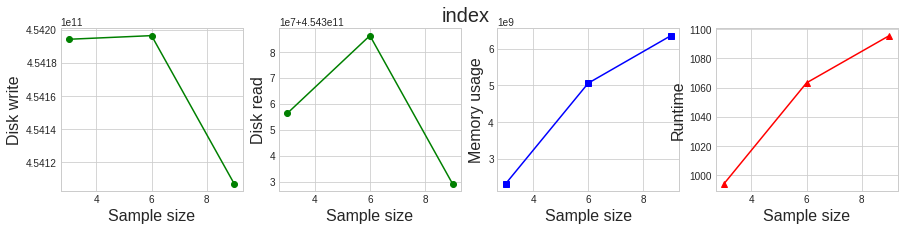

In [50]:
# Indexing Plots
plot_resources(multibench_results, sample_sizes, "index")

[{'memory': 242962432.0, 'disk_read': 17490754.0, 'disk_write': 645591.0, 'runtime': 0.89}, {'memory': 243953664.0, 'disk_read': 17496513.0, 'disk_write': 653916.0, 'runtime': 0.97}, {'memory': 242679808.0, 'disk_read': 17498195.0, 'disk_write': 646206.0, 'runtime': 0.92}]


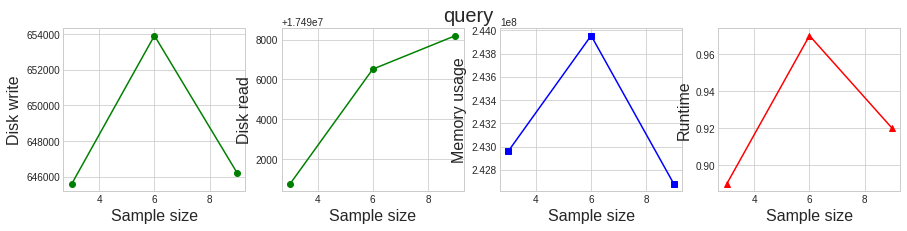

In [51]:
# Querying Plots
plot_resources(multibench_results, sample_sizes, "query")